In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Concatenate,GlobalMaxPooling2D
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision

In [2]:
def load_image(img_path,size=(80,80)):
    
    #Labeling Data
    if tf.strings.regex_full_match(img_path, ".*COVID19.*"):
        label = tf.constant(0, tf.uint8)
    elif tf.strings.regex_full_match(img_path, ".*NORMAL.*"):
        label = tf.constant(1, tf.uint8)
    else:
        label = tf.constant(2, tf.uint8)
    label = tf.one_hot(label,depth=3, on_value=1,off_value=0 )

    #read images and applying normalization
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img,channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    #image enhacement
    if tf.strings.regex_full_match(img_path, ".*train.*"):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img,0.1)
        img = tf.image.random_contrast(img,0.1,0.2)
        img = tf.image.random_saturation(img,0,5)
        img = tf.image.resize(img,size=(96,96))
        img = tf.image.random_crop(img,size=[80,80,3])

    img = tf.image.resize(img, size)
    return (img, label)

#change learning rate
def scheduler(epoch, lr=0.0001):
    if epoch < 3:
        lr=0.0004
    elif epoch <6:
        lr=0.0002
    else:
        lr=0.0001

    return lr

In [3]:
def myModel():
    inputs = Input(shape=(80,80,3))
    conv1 = Conv2D(32, (2, 2), padding='same', activation='elu')(inputs)
    conv1 = Conv2D(32, (2, 2), padding='same', activation='elu')(conv1)
    pool1 = MaxPooling2D((2, 2),strides=(2,2))(conv1)

    conv2 = Conv2D(64, (2, 2), padding='same', activation='elu')(pool1)
    conv2 = Conv2D(64, (2, 2), padding='same', activation='elu')(conv2)
    pool2 = MaxPooling2D((2, 2),strides=(2,2))(conv2)

    conv3 = Conv2D(128, (2, 2),padding='same', activation='elu')(pool2)
    conv3 = Conv2D(128, (2, 2),padding='same', activation='elu')(conv3)
    conv3 = Conv2D(128, (2, 2),padding='same', activation='elu')(conv3)
    pool3 = MaxPooling2D((2, 2),strides=(2,2))(conv3)

    conv4 = Conv2D(128, (2, 2),padding='same', activation='elu')(pool3)
    conv4 = Conv2D(128, (2, 2),padding='same', activation='elu')(conv4)
    conv4 = Conv2D(128, (2, 2),padding='same', activation='elu')(conv4)
    pool4 = MaxPooling2D((2, 2),strides=(2,2))(conv4)

    concat = Concatenate()(
        [GlobalMaxPooling2D()(pool1),
         GlobalMaxPooling2D()(pool2),
         GlobalMaxPooling2D()(pool3),
         GlobalMaxPooling2D()(pool4)])

    flatten1 = Flatten()(concat)
    flatten2 = Flatten()(conv4)
    concat2 = Concatenate()([flatten1,flatten2])

    x = Dense(4096, activation='elu')(concat2) 
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='elu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(3, activation='softmax')(x)

    return models.Model(inputs=inputs,outputs=outputs)
 

In [4]:
   
if __name__ == "__main__":

    BATCH_SIZE = 32
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

    train_data = tf.data.Dataset.list_files("./train/*/*.*")\
                                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                                .shuffle(buffer_size=1280).batch(BATCH_SIZE) \
                                .prefetch(tf.data.experimental.AUTOTUNE)
    validation_data = tf.data.Dataset.list_files("./validation/*/*.*")\
                                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                                .shuffle(buffer_size=1280).batch(BATCH_SIZE) \
                                .prefetch(tf.data.experimental.AUTOTUNE)
    test_data = tf.data.Dataset.list_files("./test/*/*.*")\
                                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                                .batch(BATCH_SIZE) \
                                .prefetch(tf.data.experimental.AUTOTUNE)

    # new_model = tf.keras.models.load_model('./covid19.h5') #same file path
    # new_model.evaluate(covid_data)
    # new_model.summary()
                                   
    model = myModel()

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.12)
    adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    start = time.time()
    model.compile(
                loss=loss,
                optimizer=adam,
                metrics=[CategoricalAccuracy(name="accuracy"),Recall(),Precision()]
                  )

    history=model.fit(train_data,
              epochs=15,
              class_weight={0:2.5,1:3.18,2:1},
              validation_data=validation_data,
              callbacks=[tensorboard_callback,scheduler_callback]
              )

#     model.evaluate(test_data)
#     model.evaluate(covid_data)

    end = time.time()
    print(f"Runtime of the program is {end - start}")
    model.summary()
    model.save('covid19-32f.h5')


Epoch 1/15
177/177 [==============================] - 174s 969ms/step - loss: 4.0131 - accuracy: 0.5790 - recall: 0.5277 - precision: 0.5963 - val_loss: 0.8771 - val_accuracy: 0.6598 - val_recall: 0.6112 - val_precision: 0.6664
Epoch 2/15
177/177 [==============================] - 172s 964ms/step - loss: 1.6313 - accuracy: 0.8097 - recall: 0.7671 - precision: 0.8286 - val_loss: 0.7219 - val_accuracy: 0.7513 - val_recall: 0.7162 - val_precision: 0.7696
Epoch 3/15
177/177 [==============================] - 173s 969ms/step - loss: 1.4957 - accuracy: 0.8486 - recall: 0.8161 - precision: 0.8679 - val_loss: 0.6044 - val_accuracy: 0.8306 - val_recall: 0.8127 - val_precision: 0.8542
Epoch 4/15
177/177 [==============================] - 172s 963ms/step - loss: 1.2890 - accuracy: 0.9143 - recall: 0.8902 - precision: 0.9291 - val_loss: 0.6124 - val_accuracy: 0.8370 - val_recall: 0.8134 - val_precision: 0.8544
Epoch 5/15
177/177 [==============================] - 172s 965ms/step - loss: 1.1901 - a

In [50]:
test_data = tf.data.Dataset.list_files("./test/*/*.*")\
                                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                                .batch(BATCH_SIZE) \
                                .prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
new_model = tf.keras.models.load_model('./covid19-32f.h5')
model.evaluate(test_data)

46/46 [==============================] - 8s 170ms/step - loss: 0.5489 - accuracy: 0.8903 - recall: 0.8649 - precision: 0.9131


[0.5489452481269836, 0.890260636806488, 0.8648834228515625, 0.9131064414978027]

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 

In [7]:
history.history

{'loss': [2.4529590606689453,
  1.6064696311950684,
  1.5118353366851807,
  1.2739723920822144,
  1.1997336149215698,
  1.1422415971755981,
  1.0633522272109985,
  1.0293577909469604,
  1.0099488496780396,
  0.9895444512367249,
  0.974277675151825,
  0.9645833969116211,
  0.9561775326728821,
  0.9411203861236572,
  0.9323233962059021],
 'accuracy': [0.6829096078872681,
  0.815854549407959,
  0.8538135886192322,
  0.917019784450531,
  0.9389124512672424,
  0.9583333134651184,
  0.9775776863098145,
  0.9862288236618042,
  0.990289568901062,
  0.9945268630981445,
  0.9959392547607422,
  0.9971751570701599,
  0.9971751570701599,
  0.9982344508171082,
  0.9989407062530518],
 'recall': [0.6262359023094177,
  0.7757768630981445,
  0.8193855881690979,
  0.8963630199432373,
  0.9201977252960205,
  0.9461511373519897,
  0.9705155491828918,
  0.9804025292396545,
  0.9846398234367371,
  0.9922316670417786,
  0.9931144118309021,
  0.994350254535675,
  0.9968220591545105,
  0.9971751570701599,
  0.9

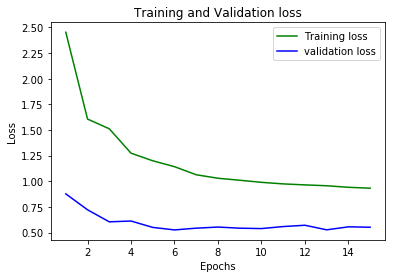

In [9]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

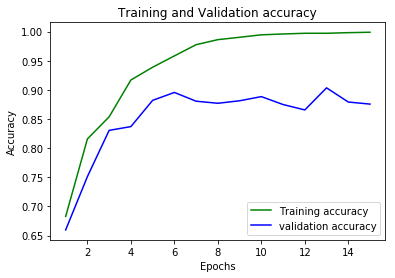

In [11]:
loss_train = np.array(history.history['accuracy'])
loss_val = np.array(history.history['val_accuracy'])
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
BATCH_SIZE= 32
my_data = tf.data.Dataset.list_files("./my/*.*")\
                                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                                .batch(BATCH_SIZE) \
                                .prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
new_model.predict(my_data)

array([[0.28041616, 0.60680443, 0.11277939]], dtype=float32)

In [16]:
from keras.callbacks import ModelCheckpoint

In [17]:
layer_outputs = [layer.output for layer in new_model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=new_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [18]:
activations = activation_model.predict(my_data) # Returns a list of five Numpy arrays: one array per layer activation


In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 80, 80, 3)


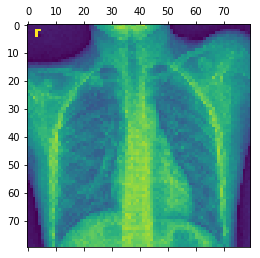

In [20]:
plt.matshow(first_layer_activation[0, :, :,1], cmap='viridis')


RuntimeError: libpng signaled error

<Figure size 2016x0 with 1 Axes>

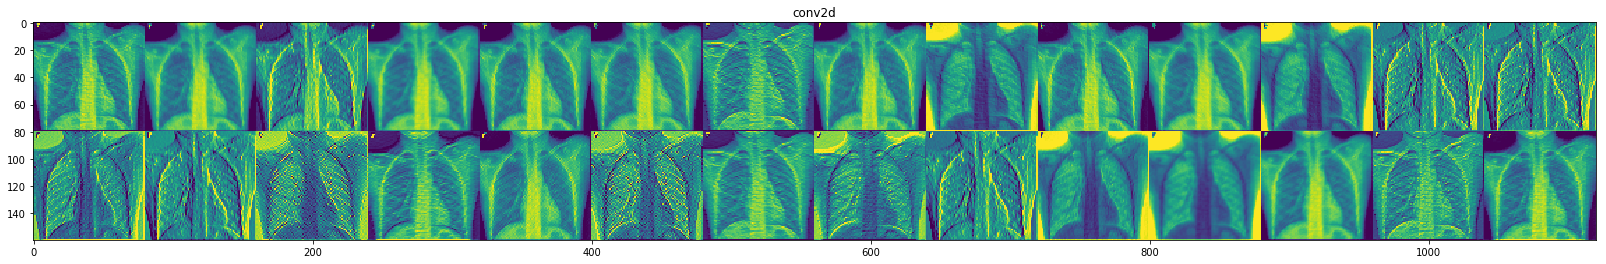

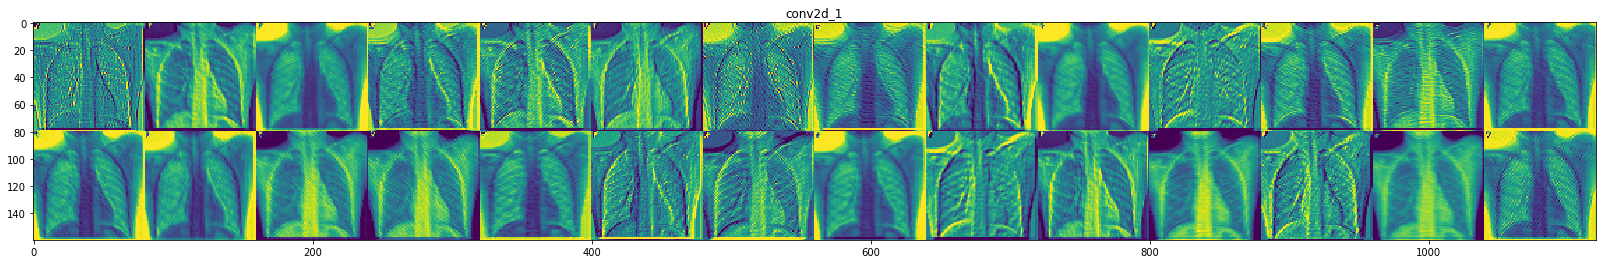

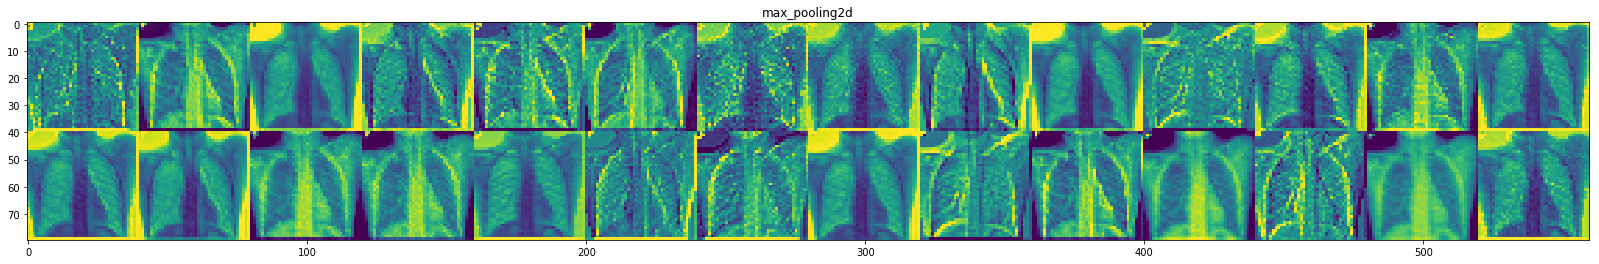

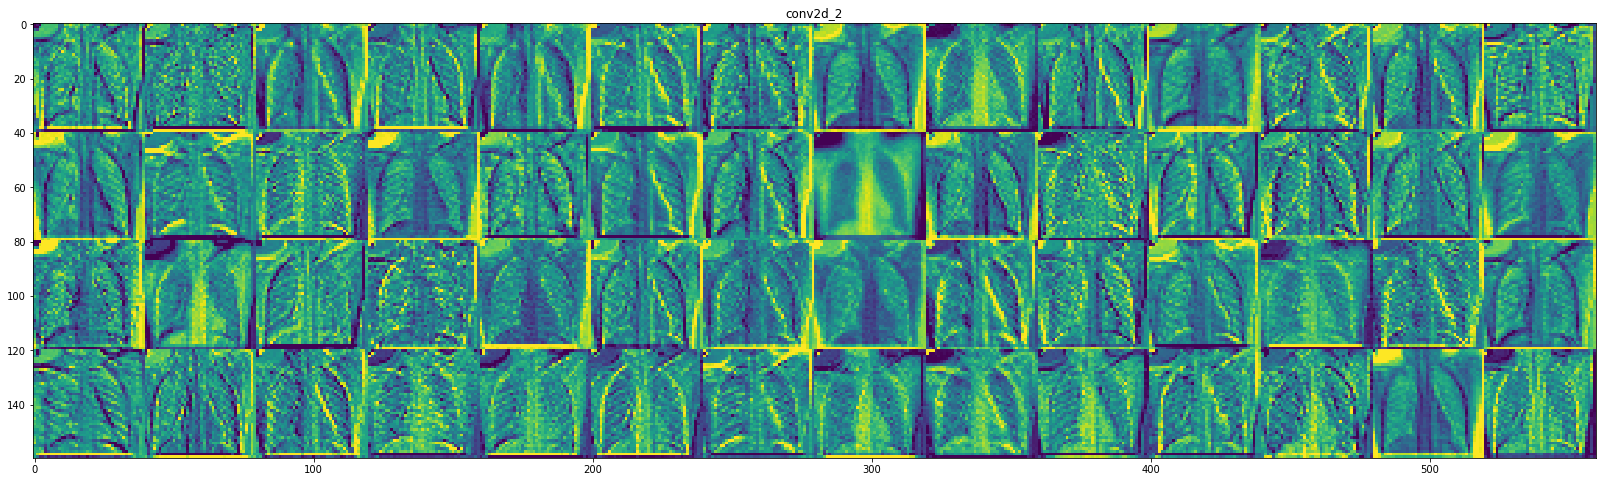

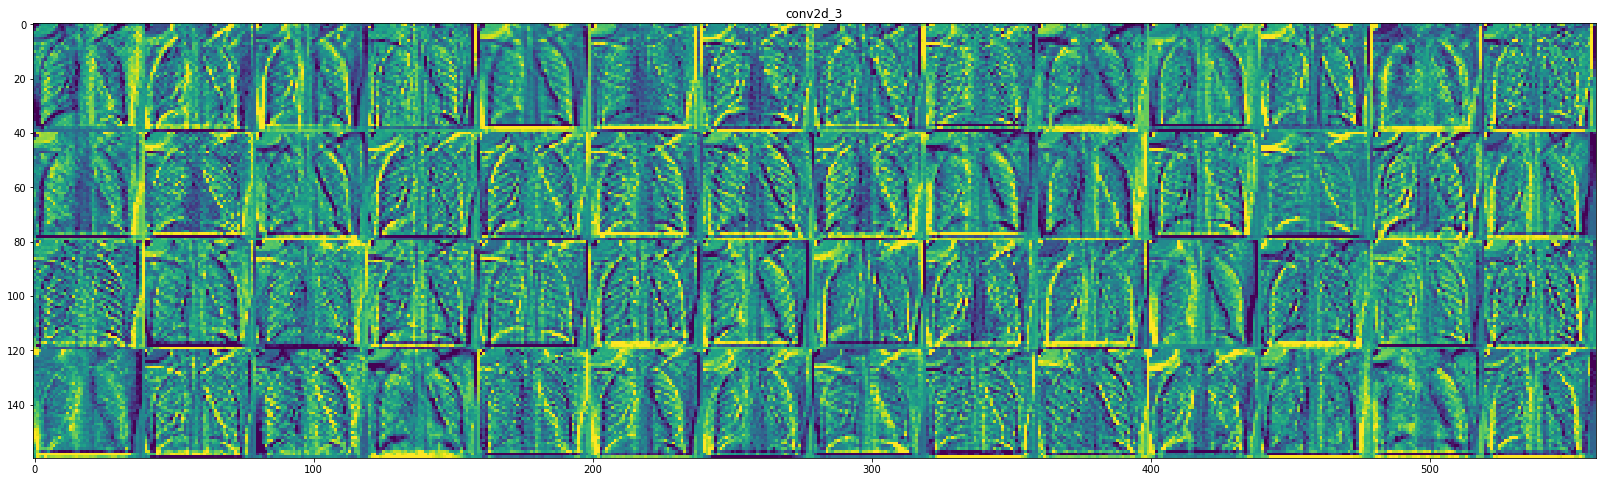

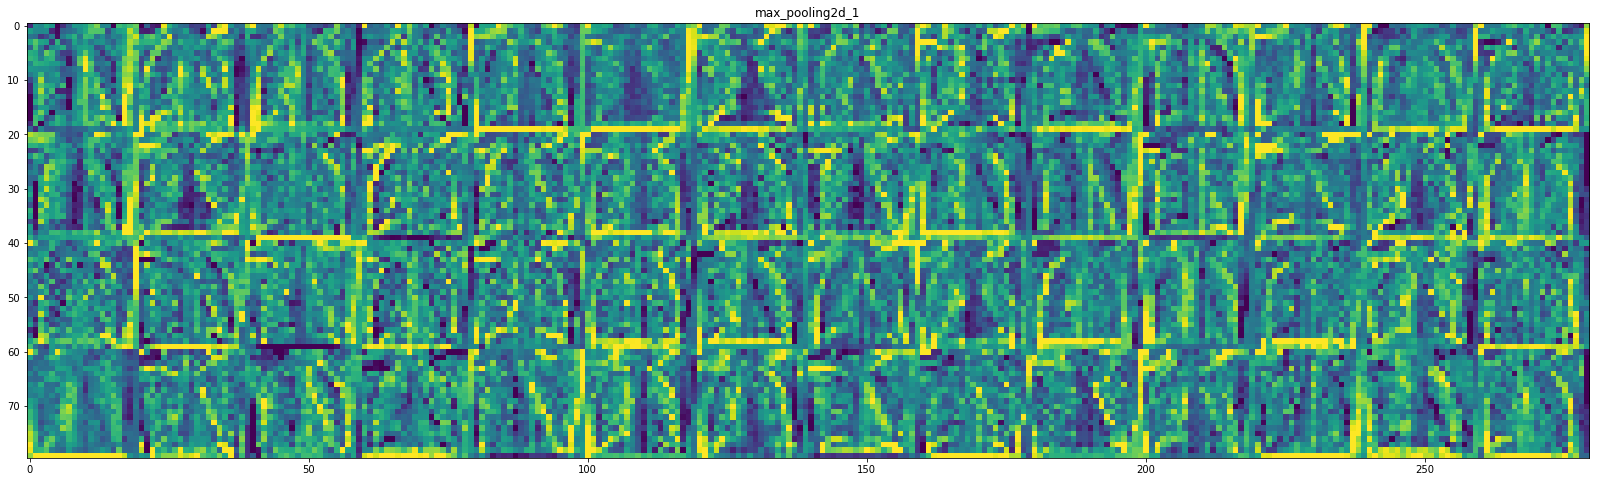

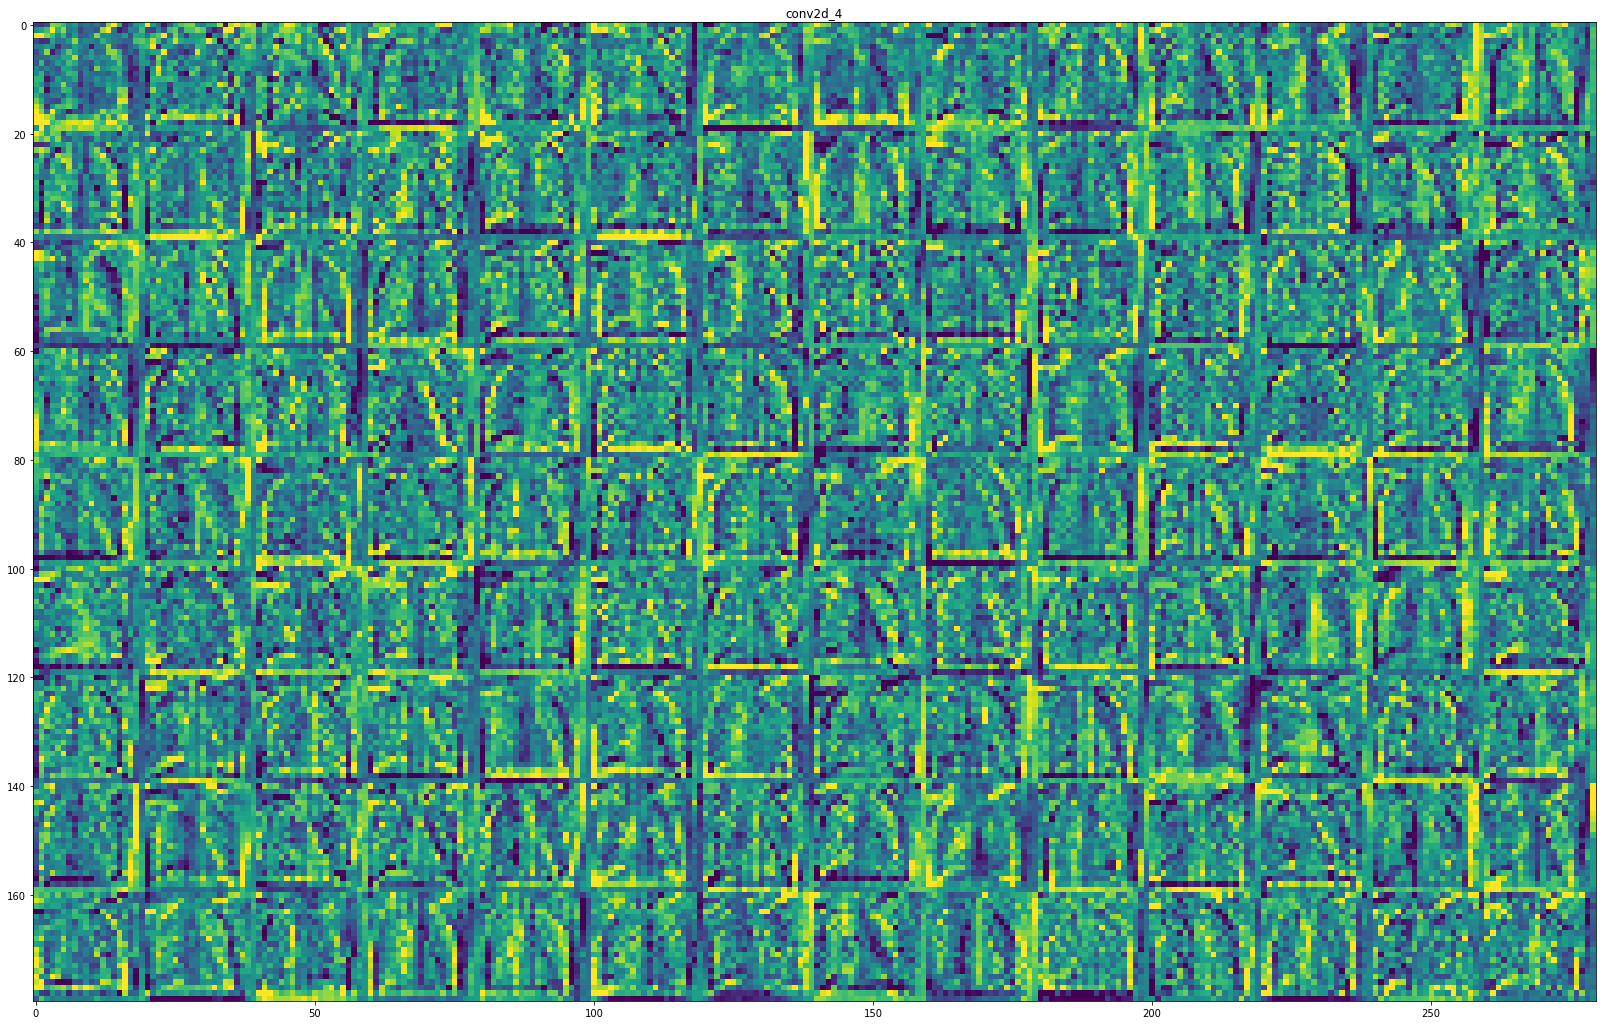

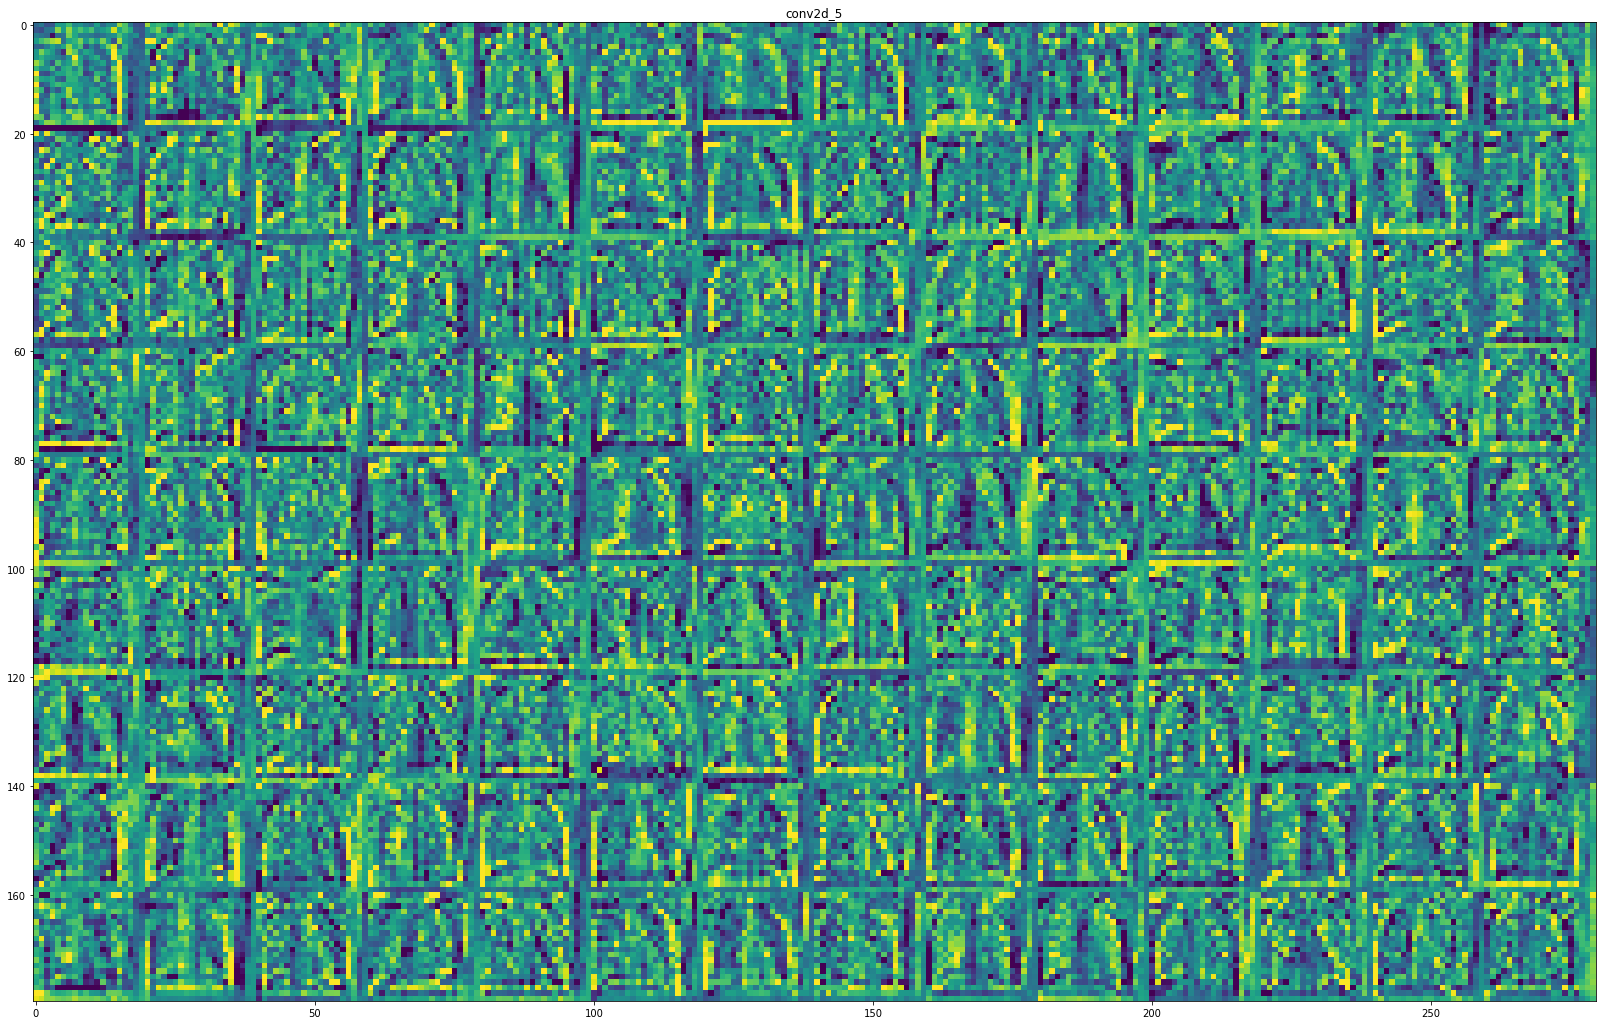

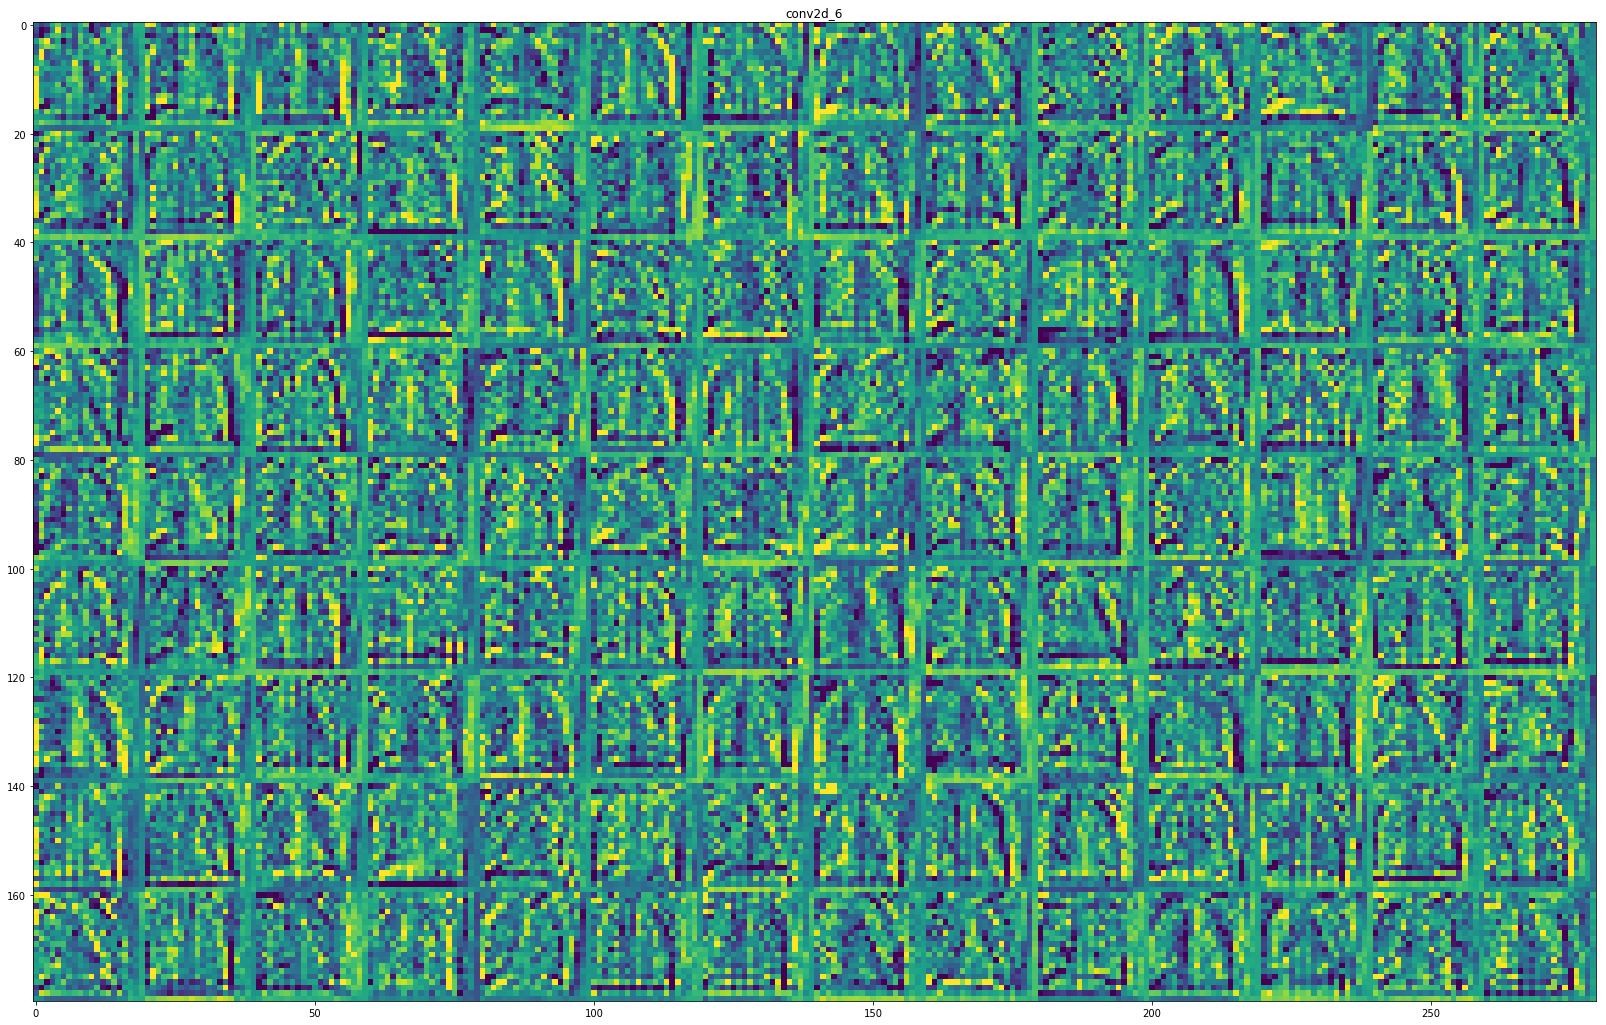

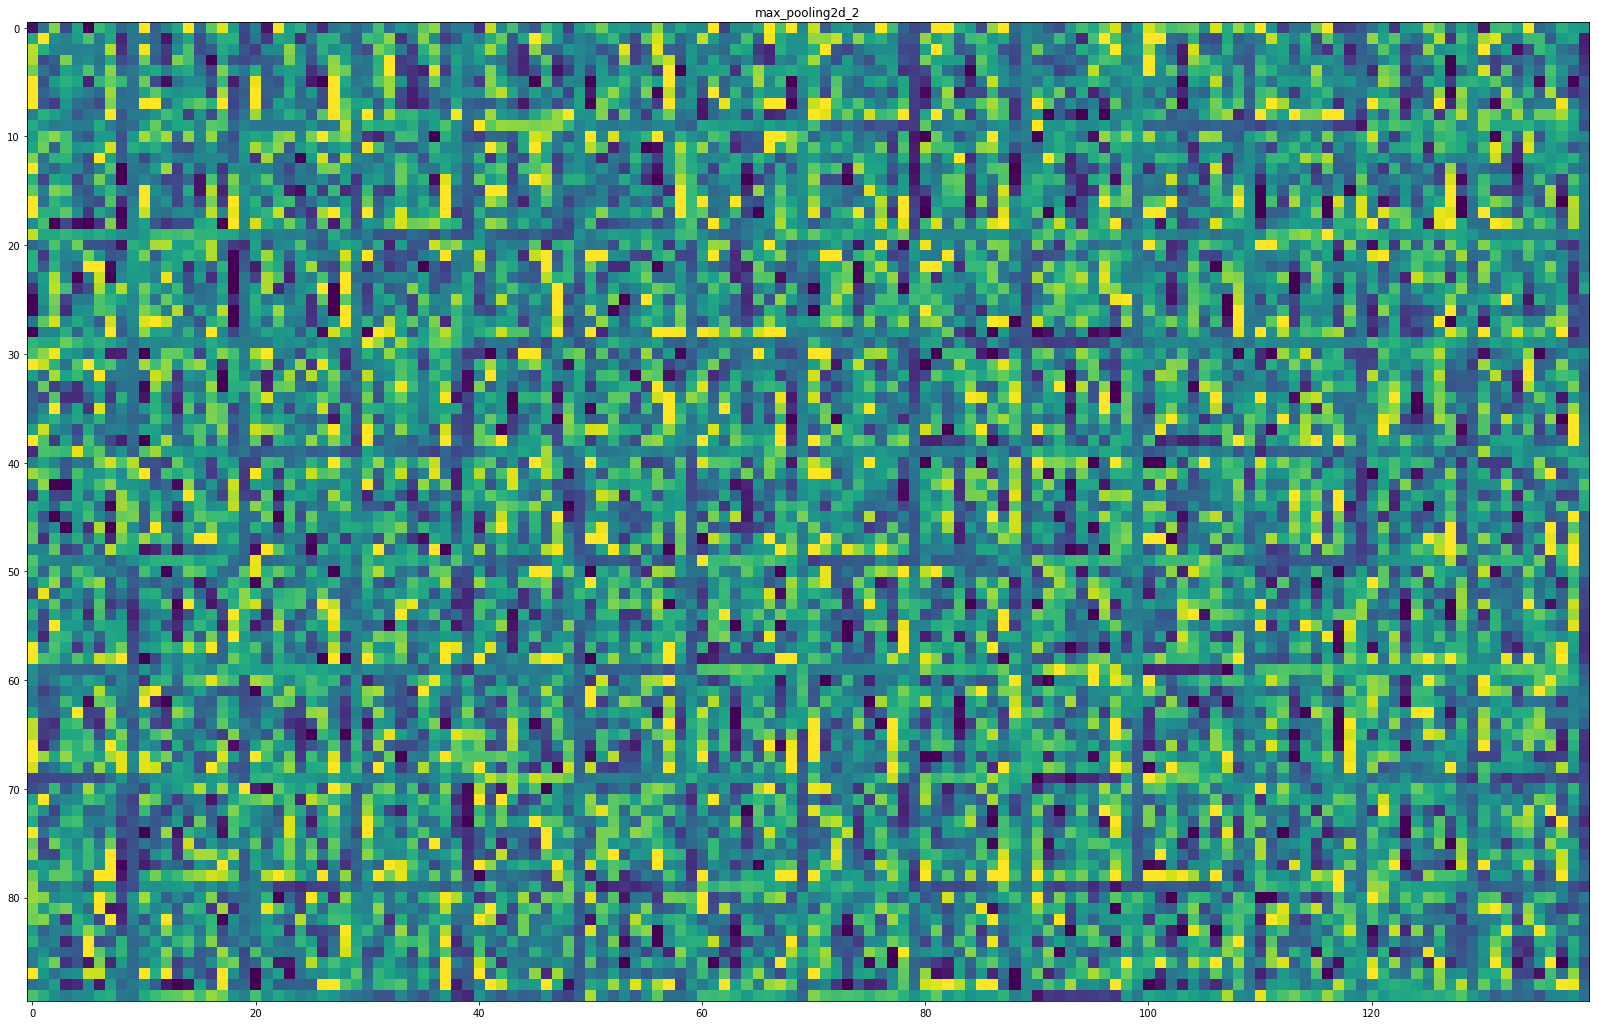

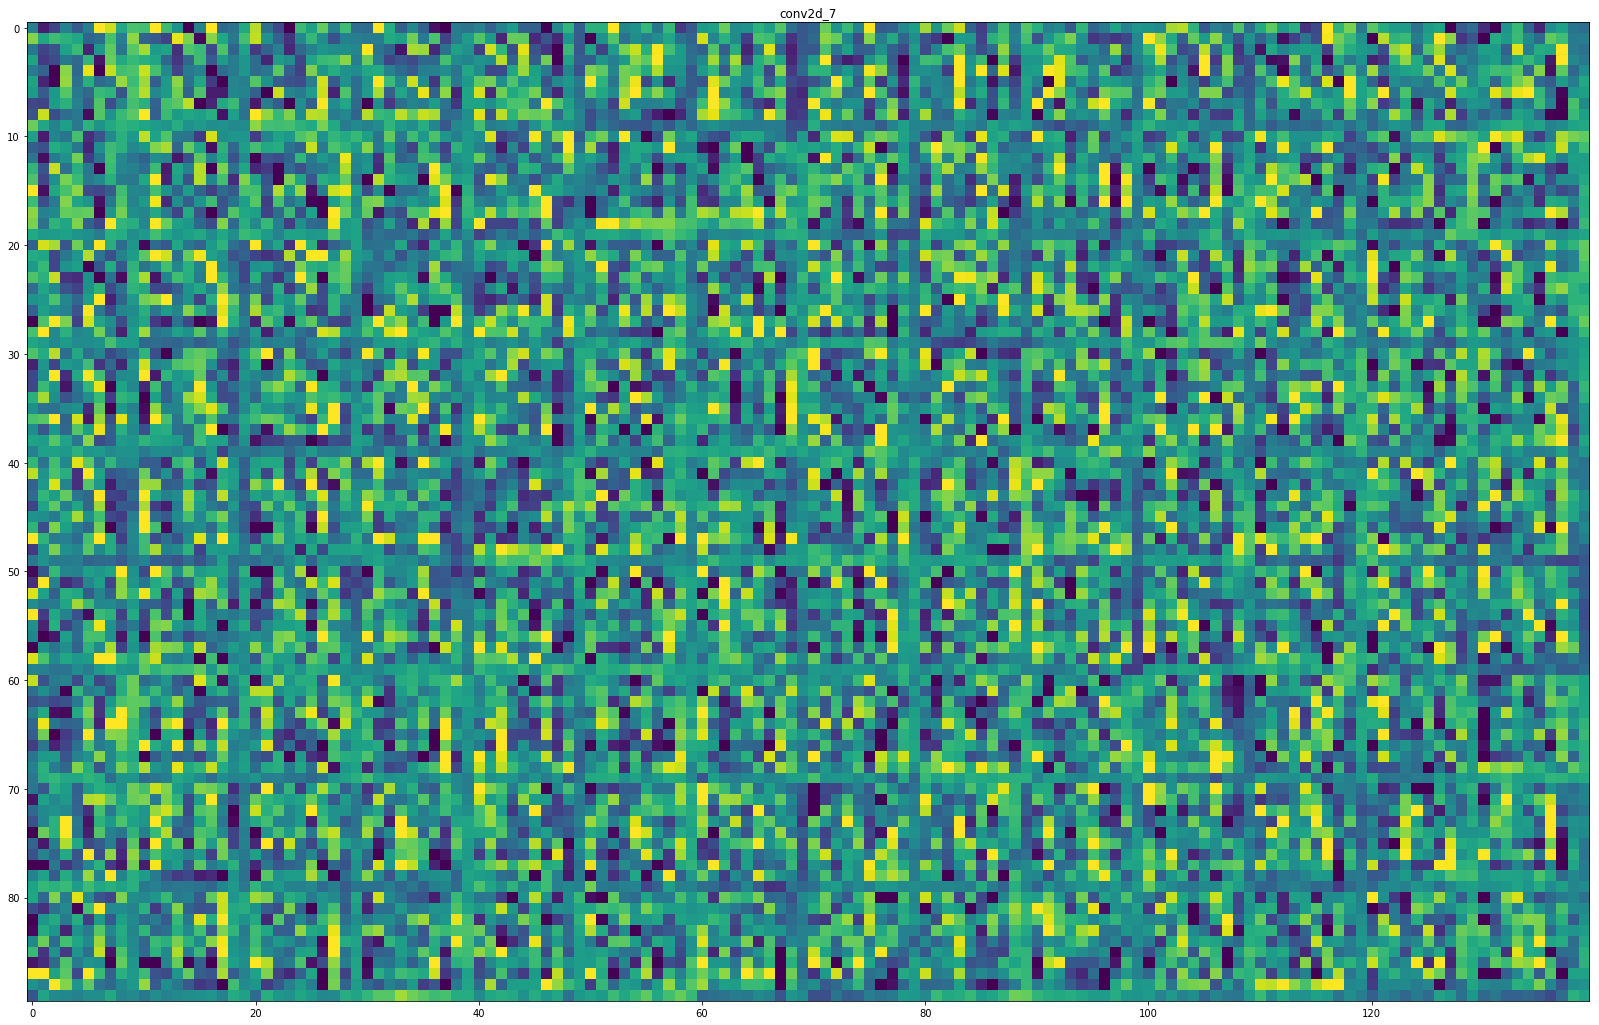

In [22]:
layer_names = []
for layer in new_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 14

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 2.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')